## Импорт модулей

In [27]:
# Работа с многомерными массивами
import numpy as np

# магическая команда для включения интерактивного режима
%matplotlib notebook 

# Визуализация расчетов
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.widgets import Slider

## Математическая постановка задачи

Квазилинейное уравнение переноса в дивергентном виде:

\begin{equation}
\begin{cases}
\frac{\partial}{\partial t}u + \frac{\partial}{\partial x}arctg(u^{4}+1) = 0, 0<x\leq 1, t>0 \\
u(x, 0) = x^2, \\
u(0, t) = 0.
\end{cases}
\end{equation}

## Шаблон безусловно устойчивой трехточечной разностной схемы

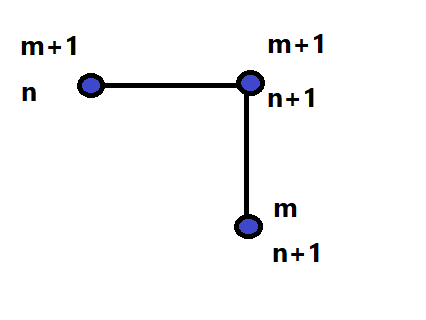

## Границы области

In [28]:
X_min, X_max = 0, 1 
T_min, T_max = 0, 1

## Метод Ньютона

In [29]:
def newton(f, d_f, x0, eps=10**(-5), k_max=10000):
    k=0
    previous_result = x0 # инициализируем предыдущий результат начальным приближением
    result = previous_result - f(previous_result)/d_f(previous_result)
    while(abs(result-previous_result) >= eps and k < k_max): # пока не достигнута точность и число итераций меньше максимального
        k+=1
        previous_result = result
        result = previous_result - f(previous_result)/d_f(previous_result)
    return result

## Метод дихотомии

In [30]:
def MPD(f, a, b, eps=1e-5):
    while abs(b - a) > eps:
        x = (a + b) / 2.0
        if (f(x) * f(a)) > 0:
            a = x
        else:
            b = x
    return x

## Поиск численного решения при помощи схемы бегущего счета

In [31]:
# полный численный поток (c*du/dx)
def total_flux(y):
    return np.arctan(1+y**4)


# частная производная полного численного потока по u
def Dv_total_flux(y):
    alpha = 4 * y ** 3
    beta = 1 + (1 + y ** 4) ** 2
    return alpha/beta


# разностное уравнение
def difference_equation(v, u, m, n, tau, h): #v=u[m+1][n+1]
    return(v/tau - u[m][n+1]/tau + total_flux(v)/h - total_flux(u[m+1][n])/h)


def solve_equation(N, M):
    """
    Решатель 1D квазилинейного уравнения переноса.
    N - количество узлов вдоль OX, M - количество узлов вдоль Ot.
    """
    # Массивы координат 
    X = np.linspace(X_min, X_max, N)
    T = np.linspace(T_min, T_max, M)

    h = np.abs(float((X_max - X_min)/(N-1)))   # шаг по координате
    tau = np.abs(float((T_max - T_min)/(M-1))) # шаг по времени
    
    # Инициализация сеточной функции u[t][x] и учет дополнительных условий
    u = np.zeros((M, N), dtype=float)
    u[0,:] = X ** 2 # начальные условия
    u[:,0] = 0 # граничные условия
    
    for i in range(1, M):
        for j in range(1, N):
            u[i, j] = newton(lambda v: difference_equation(v, u, i-1, j-1, tau, h),
                             lambda v: 1/tau + Dv_total_flux(v)/h,
                             u[i-1][j])
    
    return [X, T, u]

## Решение при N = 1001, M = 1001

In [32]:
[X, T, u_numerical] = solve_equation(1001, 1001)

## Визуализация численного решения

<IPython.core.display.Javascript object>


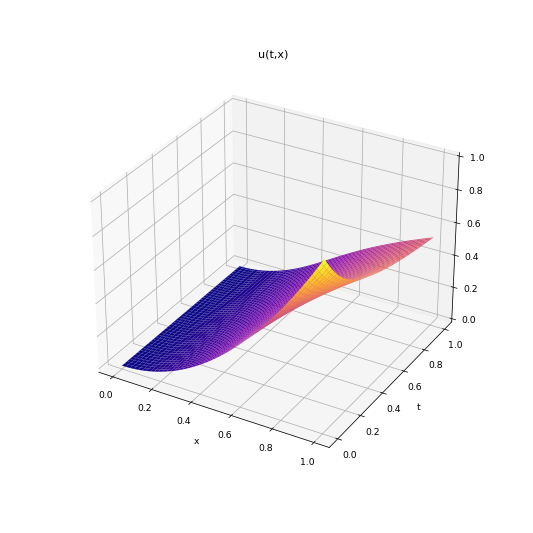

Text(0.5, 0, 't')

In [33]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
x_mesh, t_mesh = np.meshgrid(X, T)
surf = ax.plot_surface(x_mesh, t_mesh, u_numerical, cmap='plasma')
plt.title('u(t,x)')
plt.xlabel('x')
plt.ylabel('t')

<IPython.core.display.Javascript object>


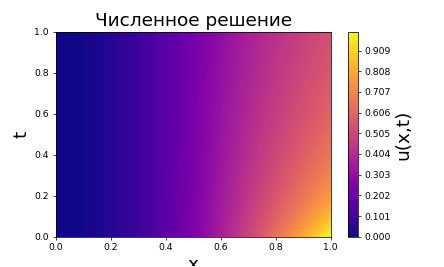

Text(0.5, 1.0, 'Численное решение')

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

q = ax.contourf(X, T, u_numerical, levels = np.linspace(0,1,100), cmap = 'plasma')

ax.set_ylabel(r't',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb = fig.colorbar(q,ax=ax)
clb.set_label(r'u(x,t)',fontsize=20)
fig.set_figwidth(10)
fig.set_figheight(6)

plt.title('Численное решение', fontsize=20)

## Построение характеристик и поиск аналитического решения

In [35]:
def characteristic_curve(t, x, x0):
    return t - (x-x0)/Dv_total_flux(x0**2)


def characteristic_x0_(t, x):
    def f(z):
        return characteristic_curve(t, x, z)
    return(MPD(f, X_min+10**-5, X_max-10**-5))


def analytic(t,x):
    if (t==0):
        return x**2
    if (x==0):
        return 0
    return characteristic_x0_(t, x)**2


def analytic_solve(N, M):
    X = np.linspace(X_min, X_max, N)
    T = np.linspace(T_min, T_max, M)
    h = np.abs(float((X_max - X_min)/(N-1)))
    tau = np.abs(float((T_max - T_min)/(M-1))) 
    
    u_analytic = np.zeros((M, N), dtype=float)
    
    for i in range(0, M):
        for j in range(0, N):
            u_analytic[i, j] = analytic(i * tau, j * h)
    return [X, T, u_analytic]

## Аналитическое решение при N = 1001, M = 1001

In [36]:
[X_a, T_a, u_analytic] = analytic_solve(1001, 1001)

<IPython.core.display.Javascript object>


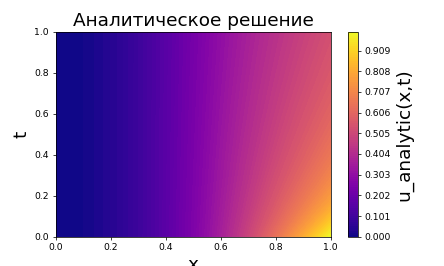

In [37]:
fig, ax = plt.subplots()

q = ax.contourf(X_a, T_a, u_analytic, 
               levels = np.linspace(0, 1, 100), 
               cmap = 'plasma')

ax.set_ylabel(r't',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb = fig.colorbar(q,ax=ax)
clb.set_label(r'u_analytic(x,t)',fontsize=20)
fig.set_figwidth(10)
fig.set_figheight(6)

plt.title('Аналитическое решение', fontsize=20)
plt.show()

## Сравнение численного и аналитического решений

<IPython.core.display.Javascript object>


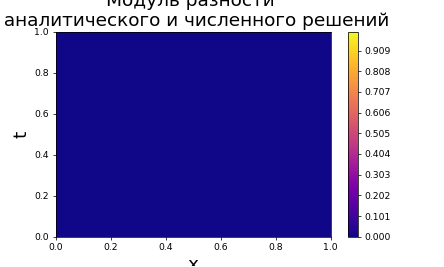

In [38]:
fig, ax = plt.subplots()

q = ax.contourf(X, T, abs(u_analytic-u_numerical), 
                levels = np.linspace(0, 1,100), 
                cmap = 'plasma')

ax.set_ylabel(r't',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)

clb = fig.colorbar(q,ax=ax)

fig.set_figwidth(10)
fig.set_figheight(6)
plt.title('Модуль разности \n аналитического и численного решений', fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


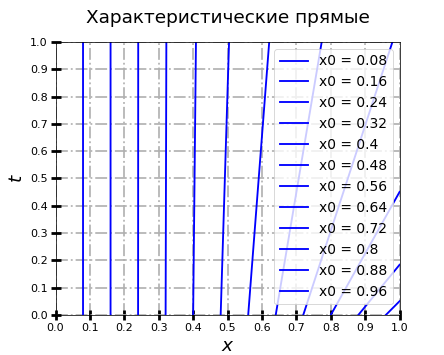

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))

# Область обображения графика
ax.set_xlim(X_min, X_max)
ax.set_ylim(T_min, T_max)

X0 = X[::80]
X0 = X0[X0>0]

T_characteristic = np.zeros((X0.shape[0], X.shape[0]), dtype=float)
index_arr = np.arange(X0.shape[0]) 
p = 0

for element in X0:
    T_characteristic[p] = (X-element)/Dv_total_flux(element**2)
    plt.plot(X, T_characteristic[p], 
             color="blue", 
             linewidth=2, 
             label=('x0 = ' + str(round(element, 3))))
    p+=1

# Подпись к графику
ax.set_title('Характеристические прямые', pad=20, fontsize = 20)


# Обозначения координатных осей
plt.xlabel(r'$x$', fontsize = 20)
plt.ylabel(r'$t$', fontsize = 20)

# Отображение легенды графика
plt.legend(loc='upper right', fontsize = 15)

# Сетка
plt.grid(linestyle='-.', linewidth=2, alpha=0.9)

# Деления на осях
plt.tick_params(labelcolor='black', 
                labelsize='large', width=3, 
                direction='inout', length=10)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Отображение графика
plt.show()

<IPython.core.display.Javascript object>


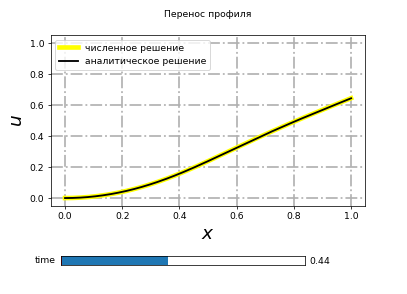

In [45]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.3)

ax.set_title('Перенос профиля', pad=20, fontsize = 10)

tau = np.abs(float((T_max - T_min)/(T.shape[0]-1))) # шаг по времени

l, = plt.plot(X, u_numerical[0], linewidth=5, color='yellow', label='численное решение')
l_analytic, = plt.plot(X, u_analytic[0], linewidth=2, color='black', label='аналитическое решение')
legend = ax.legend(loc='upper left', fontsize=10)
plt.grid(linestyle='-.', linewidth=2, alpha=0.9)
plt.xlabel(r'$x$', fontsize = 20)
plt.ylabel(r'$u$', fontsize = 20)


# Create axes for frequency and amplitude sliders
axtime = plt.axes([0.15, 0.1, 0.6, 0.03])

time = Slider(axtime, 'time', T_min, T_max, T_min, valstep=abs(T_max-T_min)/50)

def update(val):
    t = time.val
    l.set_ydata(u_numerical[int(t/tau)])
    l_analytic.set_ydata(u_analytic[int(t/tau)])
    
time.on_changed(update)
plt.show()

## Изменение невязки при разных параметрах сетки

In [15]:
num_list = [i for i in range(10, 1000, 200)]

h_arr = np.array([np.abs(float((X_max - X_min)/(N-1))) for N in num_list])
tau_arr = np.array([np.abs(float((T_max - T_min)/(M-1))) for M in num_list])

h_plus_tau = h_arr + tau_arr

difference_between_solutions = [np.abs(analytic_solve(N, N)[2] - solve_equation(N, N)[2]).max() for N in num_list]
                                    

<IPython.core.display.Javascript object>


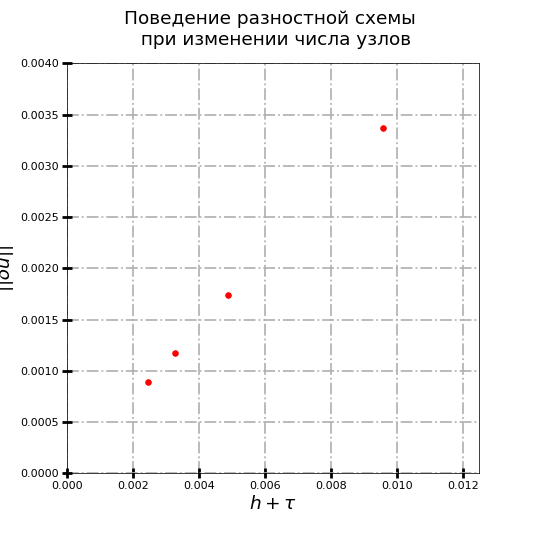

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlim(0, 0.0125)
ax.set_ylim(0, 0.004)

plt.plot(h_plus_tau, np.array(difference_between_solutions), 'o', color="red")

# Подпись к графику
ax.set_title('Поведение разностной схемы \n при изменении числа узлов', pad=20, fontsize = 20)


# Обозначения координатных осей
plt.xlabel(r'$h + \tau$', fontsize = 20)
plt.ylabel(r'$|| \delta u||$', fontsize = 20)


# Сетка
plt.grid(linestyle='-.', linewidth=2, alpha=0.9)

# Деления на осях
plt.tick_params(labelcolor='black', labelsize='large', width=3, direction='inout', length=10)

# Отображение графика
plt.show()